# Embedded ML Lab - Challenge (training yolo example)

This is an example of training with the VOC data set and tinyyolov2. Since training tinyyolo from scratch takes a very long time we start with pretrained weights.

In [1]:
import torch

# A subset of VOCDataLoader just for one class (person) (0)
from faf.utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True, path="./data")
loader_test = VOCDataLoaderPerson(train=False, batch_size=1, path="./data")

from faf.tinyyolov2 import TinyYoloV2
from faf.utils.loss import YoloLoss
import tqdm

# load cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.__version__

'1.8.1+cu102'

In [3]:
# We define a tinyyolo network with only two possible classes
net = TinyYoloV2(num_classes=1)
sd = torch.load("./weights/voc_pretrained.pt")

#We load all parameters from the pretrained dict except for the last layer
net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)
net.eval()

# Definition of the loss
criterion = YoloLoss(anchors=net.anchors)

#We only train the last layer (conv9)
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=0.001)

In [4]:
from faf.utils.ap import precision_recall_levels, ap, display_roc
from faf.utils.yolo import nms, filter_boxes

NUM_TEST_SAMPLES = 350
NUM_EPOCHS = 15
test_AP = []
net = net.to(device)
net.train()

for epoch in range(NUM_EPOCHS):
    if epoch != 0:
        for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            #Yolo head is implemented in the loss for training, therefore yolo=False
            output = net(input, yolo=False)
            loss, _ = criterion(output, target)
            loss.backward()
            optimizer.step()

            
    test_precision = []
    test_recall = []
    net.eval()
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
            input = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if idx == NUM_TEST_SAMPLES:
                break
                
    #Calculation of average precision with collected samples
    test_AP.append(ap(test_precision, test_recall))
    print('average precision', test_AP)

    #plot ROC
    display_roc(test_precision, test_recall)
            
            

/home/eml/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA RTX A2000 8GB Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A2000 8GB Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
  0%|          | 0/350 [00:00<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device

  0%|          | 0/17 [00:00<?, ?it/s]

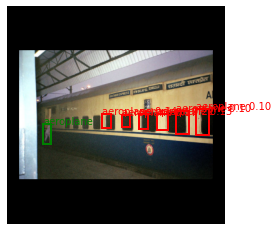

  6%|▌         | 1/17 [00:00<00:02,  7.20it/s]

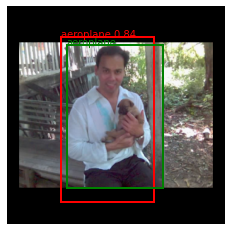

 12%|█▏        | 2/17 [00:00<00:01,  7.91it/s]

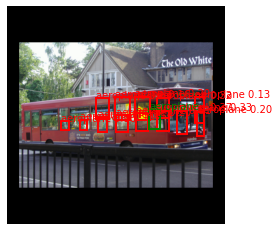

 18%|█▊        | 3/17 [00:00<00:02,  6.67it/s]

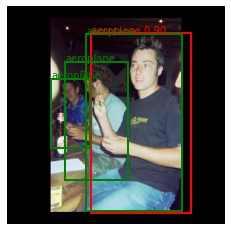

 24%|██▎       | 4/17 [00:00<00:01,  7.00it/s]

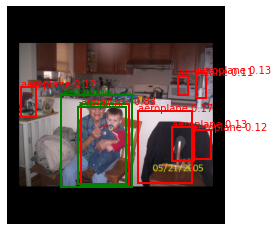

 29%|██▉       | 5/17 [00:00<00:01,  6.46it/s]

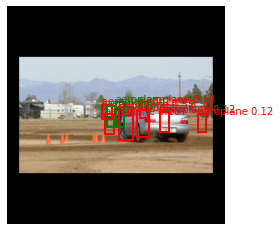

 35%|███▌      | 6/17 [00:00<00:01,  6.44it/s]

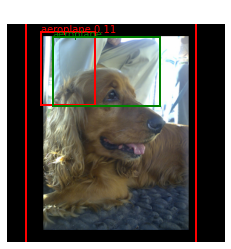

 41%|████      | 7/17 [00:01<00:01,  6.40it/s]

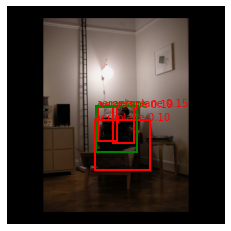

 47%|████▋     | 8/17 [00:01<00:01,  5.93it/s]

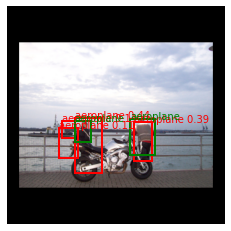

 53%|█████▎    | 9/17 [00:01<00:01,  6.18it/s]

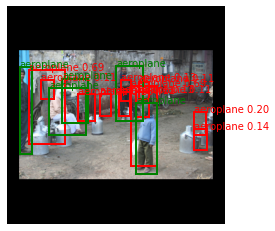

 59%|█████▉    | 10/17 [00:01<00:01,  5.95it/s]

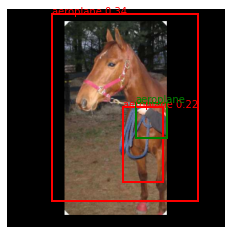

 65%|██████▍   | 11/17 [00:01<00:00,  6.44it/s]

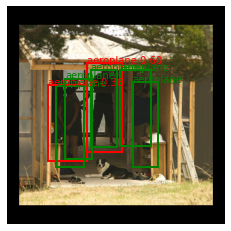

 65%|██████▍   | 11/17 [00:01<00:01,  5.90it/s]


In [17]:
import tqdm
from faf.utils.viz import display_result
net.eval()
for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=len(loader)):
    
    #input is a 1 x 3 x 320 x 320 image
    output = net(input)
    #output is a 32 x 125 x 10 x 10 tensor
    
    #filter boxes based on confidence score (class_score*confidence)
    output = filter_boxes(output, 0.1)
    
    #filter boxes based on overlap
    output = nms(output, 0.25)
    display_result(input, output, target, file_path='yolo_prediction.png')

    if idx > 10:
        break